In [1]:
!pip install networkx pyvis

In [3]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import random
import numpy as np
from datetime import datetime
import os

In [4]:
# Load the cross-border transaction data
df = pd.read_csv('synthetic_data_with_risk.csv')

# Display the first few rows to understand the structure
df.head()

,customer_account_number,recipient_account_number,sender_country,recipient_country,transaction_amount,transaction_currency,base_currency_amount,transaction_type,purpose_code,sender_risk_profile,...,device_used,ip_location,sanctions_check_status,is_fraud,transaction_id,transaction_timestamp,correspondent_bank_id,fraud_pattern,risk_score,risk_category
0,ACC00000275,REC00000026,USA,Australia,2839.43,CHF,27907.40,SWIFT,Travel Expenses,3.1,...,Mobile App,UK,CLEARED,1,TXN0000001001,2023-06-02 05:15:01,BARC004,ip_mismatch,52.6,High
1,ACC00000455,REC00000632,Myanmar,Nigeria,83510.51,CHF,6098.99,SWIFT,Consulting Services,4.5,...,Third-party Service,Nigeria,PENDING_REVIEW,1,TXN0000001002,2025-03-16 11:03:53,NaN,sanctions_evasion,82.0,Critical
2,ACC00000091,REC00000258,Turkey,Myanmar,6632.93,EUR,5565.23,Wire Transfer,Consulting Services,4.9,...,API,Canada,FLAGGED,1,TXN0000001003,2025-03-10 19:52:13,UBSW008,round_dollar_amounts,80.4,Critical
3,ACC00000031,REC00000592,Germany,Singapore,6135.69,CAD,10318.15,SEPA,Travel Expenses,3.7,...,Mobile App,Japan,CLEARED,0,TXN0000001004,2025-02-18 12:11:35,UBSW008,NaN,43.2,Medium
4,ACC00000025,REC00000223,UK,Singapore,5292.79,CNY,3243.02,CHAPS,Salary Payment,1.5,...,API,UAE,CLEARED,0,TXN0000001005,2024-02-24 23:11:30,BNPP006,NaN,36.0,Medium


In [5]:
# Check basic information about the dataset
print(f"Total transactions: {len(df)}")
print(f"Unique sender accounts: {df['customer_account_number'].nunique()}")
print(f"Unique recipient accounts: {df['recipient_account_number'].nunique()}")
print(f"Fraudulent transactions: {df['is_fraud'].sum()} ({df['is_fraud'].mean():.2%})")

Total transactions: 10000
Unique sender accounts: 500
Unique recipient accounts: 985
Fraudulent transactions: 4001 (40.01%)


In [6]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes for all unique accounts (both senders and recipients)
sender_accounts = set(df['customer_account_number'])
recipient_accounts = set(df['recipient_account_number'])
all_accounts = sender_accounts.union(recipient_accounts)

# Add nodes with attributes
for account in all_accounts:
    # Check if this account appears as a sender
    is_sender = account in sender_accounts
    # Check if this account appears as a recipient
    is_recipient = account in recipient_accounts
    
    # Determine account type based on its appearance in the dataset
    if is_sender and is_recipient:
        account_type = 'both'
    elif is_sender:
        account_type = 'sender'
    else:
        account_type = 'recipient'
    
    # Add node with attributes
    G.add_node(account, 
               account_type=account_type)

# Add edges for transactions with attributes
for _, row in df.iterrows():
    sender = row['customer_account_number']
    recipient = row['recipient_account_number']
    
    # Skip self-loops if any
    if sender == recipient:
        continue
    
    # Check if there's already an edge between these nodes
    if G.has_edge(sender, recipient):
        # If edge exists, update the weight (number of transactions)
        G[sender][recipient]['weight'] += 1
        G[sender][recipient]['total_amount'] += row['transaction_amount']
        
        # Add this transaction to the list of transactions for this edge
        G[sender][recipient]['transactions'].append(row['transaction_id'])
        
        # Update fraud flag if this transaction is fraudulent
        if row['is_fraud'] == 1:
            G[sender][recipient]['has_fraud'] = True
    else:
        # Create new edge with attributes
        G.add_edge(sender, recipient, 
                  weight=1,  # Initial weight is 1 transaction
                  total_amount=row['transaction_amount'],
                  transactions=[row['transaction_id']],
                  has_fraud=row['is_fraud'] == 1)

# Print basic graph statistics
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph created with 1485 nodes and 9849 edges


In [7]:
# Calculate basic network metrics
print("Network Analysis:")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")
print(f"Network density: {nx.density(G):.6f}")

# Identify important nodes
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

top_receivers = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:10]
top_senders = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 receivers (highest in-degree):")
for account, degree in top_receivers:
    print(f"{account}: {degree} incoming transactions")

print("\nTop 10 senders (highest out-degree):")
for account, degree in top_senders:
    print(f"{account}: {degree} outgoing transactions")

# Calculate betweenness centrality (identifies bridge accounts)
# This can be computationally expensive for large graphs
if G.number_of_nodes() < 1000:  # Only calculate for smaller graphs
    betweenness = nx.betweenness_centrality(G)
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("\nTop 10 bridge accounts (highest betweenness centrality):")
    for account, centrality in top_betweenness:
        print(f"{account}: {centrality:.6f}")

Network Analysis:
Number of connected components: 1
Network density: 0.004469

Top 10 receivers (highest in-degree):
REC00000267: 42 incoming transactions
REC00000521: 41 incoming transactions
REC00000015: 35 incoming transactions
REC00000126: 32 incoming transactions
REC00000523: 30 incoming transactions
REC00000193: 29 incoming transactions
REC00000479: 28 incoming transactions
REC00000236: 27 incoming transactions
REC00000522: 26 incoming transactions
REC00000011: 26 incoming transactions

Top 10 senders (highest out-degree):
ACC00000472: 70 outgoing transactions
ACC00000078: 68 outgoing transactions
ACC00000250: 50 outgoing transactions
ACC00000486: 44 outgoing transactions
ACC00000450: 44 outgoing transactions
ACC00000100: 42 outgoing transactions
ACC00000439: 42 outgoing transactions
ACC00000098: 42 outgoing transactions
ACC00000302: 40 outgoing transactions
ACC00000369: 40 outgoing transactions


Created visualization subgraph with 600 nodes and 2712 edges


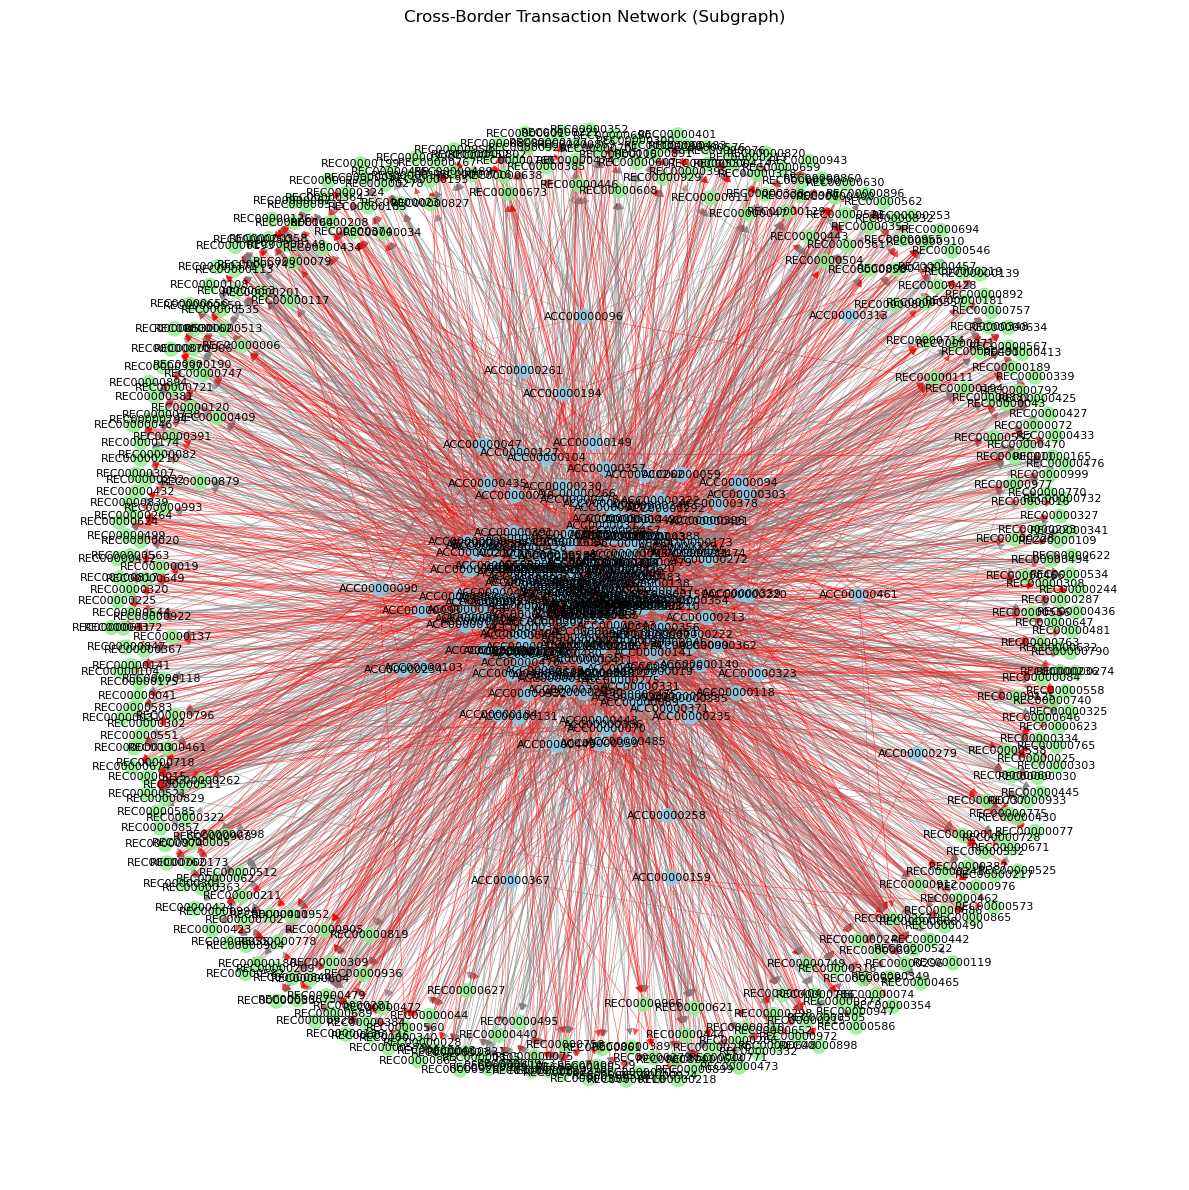

In [8]:
# Create a smaller subgraph for visualization
# Taking the top senders and receivers and their connections
top_accounts = set([account for account, _ in top_senders + top_receivers])
subgraph_nodes = set()

# Add neighbors of top accounts
for account in top_accounts:
    subgraph_nodes.add(account)
    subgraph_nodes.update(G.predecessors(account))
    subgraph_nodes.update(G.successors(account))

# Create subgraph
subgraph = G.subgraph(subgraph_nodes)
print(f"Created visualization subgraph with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

# Visualize the subgraph using matplotlib
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)  # Position nodes using force-directed layout

# Draw nodes with different colors based on account type
node_colors = []
for node in subgraph.nodes():
    if subgraph.nodes[node]['account_type'] == 'sender':
        node_colors.append('skyblue')
    elif subgraph.nodes[node]['account_type'] == 'recipient':
        node_colors.append('lightgreen')
    else:  # 'both'
        node_colors.append('orange')

# Draw edges with different colors based on fraud status
edge_colors = []
for u, v, data in subgraph.edges(data=True):
    if data['has_fraud']:
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

# Draw the network
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=0.5, alpha=0.6, arrowsize=10)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_family='sans-serif')

plt.title("Cross-Border Transaction Network (Subgraph)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Create an interactive network visualization with PyVis
net = Network(height='750px', width='100%', directed=True, notebook=True)

# Add nodes to the network
for node in subgraph.nodes():
    account_type = subgraph.nodes[node]['account_type']
    
    if account_type == 'sender':
        color = '#ADD8E6'  # Light blue
        title = f"Sender Account: {node}"
    elif account_type == 'recipient':
        color = '#90EE90'  # Light green
        title = f"Recipient Account: {node}"
    else:  # 'both'
        color = '#FFA500'  # Orange
        title = f"Sender/Recipient Account: {node}"
    
    # Add node with size based on degree
    size = 10 + (subgraph.in_degree(node) + subgraph.out_degree(node)) * 2
    net.add_node(node, title=title, color=color, size=size)

# Add edges to the network
for source, target, data in subgraph.edges(data=True):
    # Edge attributes
    width = 1 + data['weight'] * 0.5  # Width based on number of transactions
    title = f"Transactions: {data['weight']}, Total Amount: ${data['total_amount']:.2f}"
    
    if data['has_fraud']:
        color = 'red'
        title += " (Contains fraudulent transactions)"
    else:
        color = '#808080'  # Gray
    
    net.add_edge(source, target, title=title, width=width, color=color)

# Set physics layout options
net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250)

# Save and display the interactive visualization
net.save_graph('cross_border_transaction_network_syn.html')
net.show('cross_border_transaction_network_syn.html')

print("Interactive visualization saved to 'cross_border_transaction_network.html'")

cross_border_transaction_network.html
Interactive visualization saved to 'cross_border_transaction_network.html'


In [9]:
# Create a fraud-focused subgraph
fraud_edges = [(u, v) for u, v, d in G.edges(data=True) if d['has_fraud']]
fraud_nodes = set()
for u, v in fraud_edges:
    fraud_nodes.add(u)
    fraud_nodes.add(v)

fraud_graph = G.subgraph(fraud_nodes)
print(f"Fraud subgraph has {fraud_graph.number_of_nodes()} nodes and {fraud_graph.number_of_edges()} edges")

# Create interactive visualization of fraud network
fraud_net = Network(height='750px', width='100%', directed=True, notebook=True)

# Add nodes to the network
for node in fraud_graph.nodes():
    # Get all transactions involving this account
    sent_txns = [d for _, _, d in G.out_edges(node, data=True)]
    received_txns = [d for _, _, d in G.in_edges(node, data=True)]
    
    # Count fraudulent transactions
    fraud_sent = sum(1 for d in sent_txns if d['has_fraud'])
    fraud_received = sum(1 for d in received_txns if d['has_fraud'])
    
    # Determine node color based on fraud involvement
    if fraud_sent > 0 and fraud_received > 0:
        color = '#FF0000'  # Red - involved in fraud as both sender and receiver
        title = f"Account: {node} (Fraud sender & receiver)"
    elif fraud_sent > 0:
        color = '#FFA07A'  # Light salmon - involved in fraud as sender
        title = f"Account: {node} (Fraud sender)"
    elif fraud_received > 0:
        color = '#FFB6C1'  # Light pink - involved in fraud as receiver
        title = f"Account: {node} (Fraud receiver)"
    else:
        color = '#D3D3D3'  # Light gray - connected to fraud but not directly involved
        title = f"Account: {node} (Connected to fraud)"
    
    # Size based on fraud involvement
    size = 10 + (fraud_sent + fraud_received) * 5
    fraud_net.add_node(node, title=title, color=color, size=size)

# Add edges to the network
for source, target, data in fraud_graph.edges(data=True):
    width = 1 + data['weight'] * 0.5
    title = f"Transactions: {data['weight']}, Total Amount: ${data['total_amount']:.2f}"
    
    if data['has_fraud']:
        color = 'red'
        title += " (Fraudulent)"
        width += 1  # Make fraudulent edges more visible
    else:
        color = '#A9A9A9'  # Dark gray
    
    fraud_net.add_edge(source, target, title=title, width=width, color=color)

# Set physics layout options
fraud_net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250)

# Save and display the interactive visualization
fraud_net.save_graph('cross_border_fraud_network.html')
fraud_net.show('cross_border_fraud_network.html')

print("Fraud network visualization saved to 'cross_border_fraud_network.html'")

Fraud subgraph has 1351 nodes and 4535 edges
cross_border_fraud_network.html
Fraud network visualization saved to 'cross_border_fraud_network.html'


take 2

In [26]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Load the cross-border transaction data
df = pd.read_csv('cross_border_seed_data.csv')

# Create a directed graph
G = nx.DiGraph()

# Add nodes for all unique accounts
sender_accounts = set(df['customer_account_number'])
recipient_accounts = set(df['recipient_account_number'])
all_accounts = sender_accounts.union(recipient_accounts)

# Add nodes with attributes
for account in all_accounts:
    # Determine account type
    is_sender = account in sender_accounts
    is_recipient = account in recipient_accounts
    
    if is_sender and is_recipient:
        account_type = 'both'
    elif is_sender:
        account_type = 'sender'
    else:
        account_type = 'recipient'
    
    G.add_node(account, account_type=account_type)

# Add edges for transactions with attributes
for _, row in df.iterrows():
    sender = row['customer_account_number']
    recipient = row['recipient_account_number']
    
    # Skip self-loops if any
    if sender == recipient:
        continue
    
    # Check if there's already an edge between these nodes
    if G.has_edge(sender, recipient):
        # Update existing edge
        G[sender][recipient]['weight'] += 1
        G[sender][recipient]['total_amount'] += row['transaction_amount']
        G[sender][recipient]['transactions'].append(row['transaction_id'])
        
        if row['is_fraud'] == 1:
            G[sender][recipient]['has_fraud'] = True
    else:
        # Create new edge
        G.add_edge(sender, recipient, 
                  weight=1,
                  total_amount=row['transaction_amount'],
                  transactions=[row['transaction_id']],
                  has_fraud=row['is_fraud'] == 1)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Function to highlight a specific account and its connections
def highlight_account(account_number, fraud_only=False):
    """
    Create a visualization highlighting a specific account and its connections.
    
    Parameters:
    account_number (str): The account to highlight
    fraud_only (bool): If True, only show fraud-related transactions
    """
    if account_number not in G.nodes():
        print(f"Account {account_number} not found in the network.")
        return
    
    # Get account's neighbors
    predecessors = list(G.predecessors(account_number))  # Accounts that sent money to this account
    successors = list(G.successors(account_number))      # Accounts that received money from this account
    
    # Create a subgraph with the account and its direct connections
    neighbors = set(predecessors + successors + [account_number])
    subgraph = G.subgraph(neighbors)
    
    # If fraud_only, filter edges to only include fraud
    if fraud_only:
        edges_to_remove = []
        for u, v, data in subgraph.edges(data=True):
            if not data.get('has_fraud', False):
                edges_to_remove.append((u, v))
        
        subgraph_fraud = subgraph.copy()
        for edge in edges_to_remove:
            if subgraph_fraud.has_edge(*edge):
                subgraph_fraud.remove_edge(*edge)
        
        # Only keep nodes that still have connections
        nodes_to_keep = set()
        for u, v in subgraph_fraud.edges():
            nodes_to_keep.add(u)
            nodes_to_keep.add(v)
        
        subgraph = subgraph_fraud.subgraph(nodes_to_keep)
    
    # Print account summary
    print(f"\n--- Account Summary: {account_number} ---")
    
    # Incoming transactions
    incoming_edges = list(G.in_edges(account_number, data=True))
    num_incoming = len(incoming_edges)
    incoming_amount = sum(data['total_amount'] for _, _, data in incoming_edges)
    incoming_fraud = sum(1 for _, _, data in incoming_edges if data.get('has_fraud', False))
    
    # Outgoing transactions
    outgoing_edges = list(G.out_edges(account_number, data=True))
    num_outgoing = len(outgoing_edges)
    outgoing_amount = sum(data['total_amount'] for _, _, data in outgoing_edges)
    outgoing_fraud = sum(1 for _, _, data in outgoing_edges if data.get('has_fraud', False))
    
    print(f"Incoming Transactions: {num_incoming}")
    print(f"Total Received: ${incoming_amount:.2f}")
    fraud_pct = (incoming_fraud/num_incoming*100) if num_incoming > 0 else 0
    print(f"Fraudulent Incoming: {incoming_fraud} ({fraud_pct:.1f}%)")
    
    print(f"\nOutgoing Transactions: {num_outgoing}")
    print(f"Total Sent: ${outgoing_amount:.2f}")
    fraud_pct = (outgoing_fraud/num_outgoing*100) if num_outgoing > 0 else 0
    print(f"Fraudulent Outgoing: {outgoing_fraud} ({fraud_pct:.1f}%)")
    
    print(f"\nNet Flow: ${incoming_amount - outgoing_amount:.2f}")
    
    # Create a visualization using PyVis
    net = Network(height='600px', width='100%', directed=True, notebook=True)
    
    # Add nodes with different colors based on their relationship to the focus account
    for node in subgraph.nodes():
        if node == account_number:
            # Focus account
            color = '#FF5733'  # Bright orange-red
            title = f"FOCUS ACCOUNT: {node}"
            size = 30
        elif node in predecessors and node in successors:
            # Bidirectional connection
            color = '#9370DB'  # Medium purple
            title = f"Bidirectional Connection: {node}"
            size = 20
        elif node in predecessors:
            # Sent money to focus
            color = '#6495ED'  # Cornflower blue
            title = f"Sent to Focus: {node}"
            size = 20
        else:  # node in successors
            # Received money from focus
            color = '#20B2AA'  # Light sea green
            title = f"Received from Focus: {node}"
            size = 20
        
        net.add_node(node, title=title, color=color, size=size)
    
    # Add edges
    for source, target, data in subgraph.edges(data=True):
        width = 1 + data.get('weight', 1) * 0.5
        title = f"Transactions: {data.get('weight', 1)}, Total Amount: ${data.get('total_amount', 0):.2f}"
        
        if data.get('has_fraud', False):
            color = 'red'
            title += " (FRAUDULENT)"
            width += 1
        else:
            color = 'black'
        
        net.add_edge(source, target, title=title, width=width, color=color)
    
    # Set physics layout options
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250)
    
    # Display the network
    return net

# Create a simple interactive widget
def create_simple_widget():
    # Create a dropdown with all account numbers
    account_options = sorted(list(G.nodes()))
    account_dropdown = widgets.Dropdown(
        options=account_options,
        description='Account:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    
    # Create a checkbox for showing only fraud transactions
    fraud_only_checkbox = widgets.Checkbox(
        value=False,
        description='Show only fraud transactions',
        style={'description_width': 'initial'}
    )
    
    # Create a button to generate the visualization
    generate_button = widgets.Button(
        description='Highlight Account',
        button_style='primary',
        tooltip='Click to highlight the selected account'
    )
    
    # Create an output area for the visualization
    output_area = widgets.Output()
    
    # Function to handle button click
    def on_button_click(b):
        with output_area:
            clear_output()
            net = highlight_account(
                account_number=account_dropdown.value,
                fraud_only=fraud_only_checkbox.value
            )
            display(net.show('account_network.html'))
    
    # Connect the button click to the handler
    generate_button.on_click(on_button_click)
    
    # Create the final layout
    app = widgets.VBox([
        widgets.HTML("<h2>Cross-Border Transaction Network Explorer</h2>"),
        widgets.HTML("<p>Select an account to highlight its connections in the network.</p>"),
        widgets.HBox([account_dropdown]),
        widgets.HBox([fraud_only_checkbox]),
        widgets.HBox([generate_button]),
        output_area
    ])
    
    return app

# Run the simple widget
simple_widget = create_simple_widget()
display(simple_widget)

Graph created with 1493 nodes and 4975 edges
